In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [146]:
train = pd.read_csv('data/WSJ_02-21.pos', sep='\t', header=0, names=['word', 'pos'])
test = pd.read_csv('data/WSJ_24.pos', sep='\t', header=0, names=['word', 'pos'])
train.head(20)

,word,pos
0,an,DT
1,Oct.,NNP
2,19,CD
3,review,NN
4,of,IN
5,``,``
6,The,DT
7,Misanthrope,NN
8,'',''
9,at,IN


In [20]:
# Strip some non pos tags from the input data
with open('data/penn_trebank.txt', 'tr') as f:
    content = f.readlines()

tidy = {}
for i in range(0, len(content)-1, 2):
    tidy[content[i].strip()] = content[i+1].strip()
    
tags_for_removal = set(train.pos.values)- set(tidy.keys())
print(f'tags in training, but not in the original treebank set: {tags_for_removal}')

tags in training, but not in the original treebank set: {'``', ',', '#', '.', '(', '$', ':', "''", ')'}


In [147]:
#from collections import Counter
#Counter(train.itertuples(index=False, name=None)).most_common()

In [23]:
sequence_length = 5 # centre word, 2 before and 2 afer

In [97]:
input_data = []
for tup in train.itertuples(index=False, name=None):
    if tup[1] not in tags_for_removal:
        input_data.append(tup)
input_data[:20]

[('an', 'DT'),
 ('Oct.', 'NNP'),
 ('19', 'CD'),
 ('review', 'NN'),
 ('of', 'IN'),
 ('The', 'DT'),
 ('Misanthrope', 'NN'),
 ('at', 'IN'),
 ('Chicago', 'NNP'),
 ("'s", 'POS'),
 ('Goodman', 'NNP'),
 ('Theatre', 'NNP'),
 ('Revitalized', 'VBN'),
 ('Classics', 'NNS'),
 ('Take', 'VBP'),
 ('the', 'DT'),
 ('Stage', 'NN'),
 ('in', 'IN'),
 ('Windy', 'NNP'),
 ('City', 'NNP')]

In [59]:
matrix = []
for index in range(len(input_data)):
    if index+sequence_length>len(input_data):
        break
    matrix.append(input_data[index:index+sequence_length])
    index+=sequence_length

In [60]:
suffixes = []
for item in set(train['word']):
    suffixes.append(item[-3:])
    
initial_letters = []
for item in set(train['word']):
    initial_letters.append(item[0])
    
pos_vocab = set(train['pos'])
index_to_pos = {k:v for k, v in enumerate(pos_vocab)}
pos_to_index = {v:k for k, v in index_to_pos.items()}

word_vocab = set(train['word'])
print(len(word_vocab))

word_vocab.update(suffixes)
print(len(word_vocab))

word_vocab.update(initial_letters)
print(len(word_vocab))

index_to_word = {k+len(pos_vocab): v for k, v in enumerate(word_vocab)}
word_to_index = {v:k for k, v in index_to_word.items()}

print(len(word_vocab), len(pos_vocab))

44389
47551
47570
47570 45


In [136]:
from collections import Counter

winners = {}
for row in Counter(list(train.itertuples(index=False, name=None))):
    if row[0] not in winners:
        winners[row[0]] = row[1]
    elif winners[row[0]]< row[1]:
        winners[row[0]] = row[1]
        
print(f'There are {len(winners)} tuples in the dict')

for key in list(winners.keys())[:5]:
    print(key, winners[key])

There are 44389 tuples in the dict
an DT
Oct. NNP
19 CD
review VBP
of RP


In [145]:
import json
with open('jq/word_to_index.json', 'wt') as f:
    f.write(json.dumps(word_to_index))
    
with open('jq/pos_to_index.json', 'wt') as f:
    f.write(json.dumps(pos_to_index))
    
with open('jq/index_to_pos.json', 'wt') as f:
    f.write(json.dumps(index_to_pos))    
    
with open('jq/most_common_tag_for_word.json', 'wt') as f:
    f.write(json.dumps(winners))

In [100]:
def build_features(row):
    features = []

    features.append(pos_to_index[row[1][1]])
    features.append(pos_to_index[row[0][1]])

    features.append(word_to_index[row[2][0][-3:]])
    features.append(word_to_index[row[2][0][0]])
    
    features.append(word_to_index[row[2][0]])
    
    features.append(word_to_index[row[1][0]])
    
    features.append(word_to_index[row[1][0][-3:]])
    
    features.append(word_to_index[row[0][0]])
    features.append(word_to_index[row[3][0]])    
    features.append(word_to_index[row[3][0][-3:]])    
    features.append(word_to_index[row[4][0]])
    features.append(pos_to_index[row[2][1]])
    return features

In [101]:
transformed_matrix = []

for row in matrix:
    features = build_features(row)    
    transformed_matrix.append(features)  

In [83]:
def get_model(vocab_size, d_model):

    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=d_model, input_length=11))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(.1))
    model.add(layers.Dense(len(pos_vocab), activation='sigmoid'))

    return model

In [84]:
model = get_model(len(word_vocab)+len(pos_vocab), 100)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 11, 100)           4761500   
_________________________________________________________________
flatten_6 (Flatten)          (None, 1100)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               110100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 45)                4545      
Total params: 4,876,145
Trainable params: 4,876,145
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy()
              , metrics=[keras.metrics.CategoricalAccuracy()])

In [86]:
X, y = np.array(transformed_matrix)[:, :-1], keras.utils.to_categorical(np.array(transformed_matrix)[:, -1], num_classes=len(pos_vocab))
X.shape, y.shape

((832779, 11), (832779, 45))

In [95]:
max_train_size = 50000
X_train = X[:max_train_size]
X_test = X[max_train_size:max_train_size+int(.1*max_train_size)]

y_train = y[:max_train_size]
y_test = y[max_train_size:max_train_size+int(.1*max_train_size)]

Epoch 1/10
1563/1563 [==============================] - 63s 40ms/step - loss: 0.0454 - categorical_accuracy: 0.9883 - val_loss: 0.1446 - val_categorical_accuracy: 0.9610
Epoch 2/10
1563/1563 [==============================] - 65s 42ms/step - loss: 0.0075 - categorical_accuracy: 0.9977 - val_loss: 0.1670 - val_categorical_accuracy: 0.9596
Epoch 3/10
1563/1563 [==============================] - 63s 40ms/step - loss: 0.0027 - categorical_accuracy: 0.9993 - val_loss: 0.2114 - val_categorical_accuracy: 0.9560


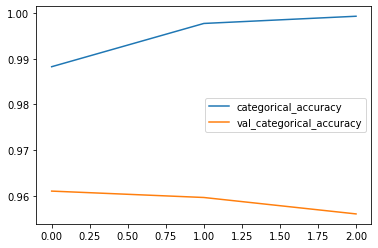

In [96]:
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=32, 
                    epochs=10, 
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=2))

for key in ['categorical_accuracy', 'val_categorical_accuracy']:
    plt.plot(history.history[key], label=key)
plt.legend()
plt.show()

In [98]:
model.save('data/model/')

INFO:tensorflow:Assets written to: data/model/assets


In [99]:
results = []
for a in range(1000):
    results.append(np.argmax(model.predict(X_test[a].reshape(1,-1)))==np.argmax(y_test[a]))
    if not a%100:
        print(np.mean(results))

1.0
0.9108910891089109
0.9303482587064676
0.9401993355481728
0.9476309226932669
0.9461077844311377
0.9517470881863561
0.9557774607703281
0.9575530586766542
0.9567147613762487


In [3]:
model = tf.keras.models.load_model('data/model')

In [5]:
np.argmax(model.predict(np.array([1,2,3,4,5,6,7,8,9,0,11]).reshape(1,-1)))

38

In [106]:
it = train.itertuples(index=False, name=None)
row = []
for a in range (5):
    row.append(next(it))

In [107]:
row

[('an', 'DT'), ('Oct.', 'NNP'), ('19', 'CD'), ('review', 'NN'), ('of', 'IN')]

In [120]:
features = build_features(row)[:-1]
features

[12, 13, 13231, 15686, 13231, 294, 42606, 4375, 18076, 20673, 43821]

In [121]:
prediction = model.predict(np.array(features).reshape(1,-1))
prediction

array([[5.6233226e-08, 9.9999976e-01, 1.5634298e-04, 1.8947423e-03,
        2.3107980e-06, 1.0539307e-07, 1.3074412e-06, 7.5778413e-01,
        4.5226748e-06, 8.5282909e-07, 1.9502640e-04, 3.1590119e-07,
        1.3349169e-01, 4.9526247e-01, 7.1832538e-04, 8.2472759e-01,
        3.2293812e-08, 8.0492100e-06, 8.1926584e-04, 9.6384263e-01,
        7.6281130e-03, 1.8671662e-02, 3.6413792e-05, 1.7106421e-08,
        4.3688919e-09, 1.2299064e-07, 1.3758950e-07, 4.3746829e-04,
        9.4354131e-05, 2.6614368e-03, 7.8414421e-05, 4.7831237e-03,
        1.2447116e-05, 1.8790201e-06, 6.0346377e-01, 2.2045739e-07,
        8.4739199e-08, 3.1835029e-07, 2.3206023e-05, 1.0895926e-04,
        1.4855266e-03, 7.5966120e-04, 4.9695373e-04, 4.4587949e-08,
        1.7301062e-07]], dtype=float32)